# Linear Discrimination

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Synthetic data example

<AxesSubplot: >

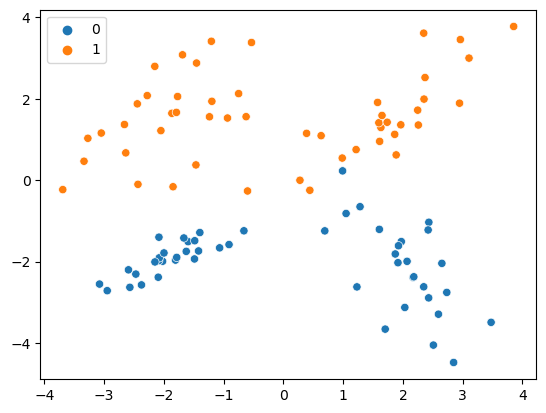

In [2]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=1.8
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)

$$
    C_i = \begin{cases} 1 & g_i(x) > 0\\ 0 & g_i(x) \leq 0 \end{cases}.
$$

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(X, Y)

# g(x) > 0 --> class 1, otherwise 0
acc_skl = np.sum((lda.decision_function(X) > 0)*1 == Y) / len(Y)

acc_diy = np.sum(((lda.coef_ @ X.T + lda.intercept_) > 0)*1 == Y) / len(Y)

print(f"{acc_skl=}, {acc_diy=}")

acc_skl=0.98, acc_diy=0.98


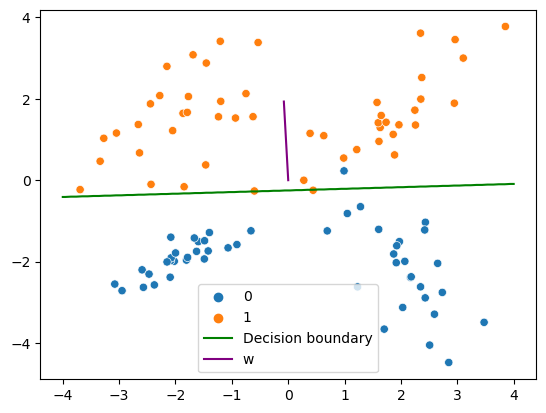

In [10]:
# create cartesian product to find decision boundary
xrange = np.linspace(-4.0, 4.0, 1000)
xx, yy = np.meshgrid(xrange, xrange)
D = np.array([xx.ravel(), yy.ravel()])
D.T

# boundary is when g(x) is almost 0
boundary = D[:, (np.abs(lda.coef_ @ D + lda.intercept_) < 0.01).ravel()]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)
plt.plot(boundary[0, :], boundary[1, :], c='g', label="Decision boundary")

plt.plot([0, lda.coef_[0, 0]*.5], [0, lda.coef_[0, 1]*.5], c='purple', label="w")
plt.legend()

In [5]:
lda.intercept_

array([0.97188544])

In [16]:
sigm = lambda x: 1/(1 + np.exp(-x))

np.sum((sigm(lda.coef_ @ X.T + lda.intercept_) - Y)**2)

1.6604740448812052

## Iris dataset example

In [156]:
from sklearn.datasets import load_iris

dataset = load_iris()

X = dataset['data'][:, [0, 1]]
Y = dataset['target']

dataset['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

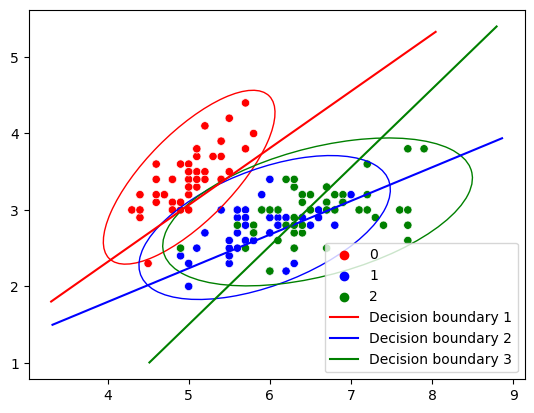

In [160]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def add_ellipse(means, cov, color, ax):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    radius_x = np.sqrt(1+pearson)
    radius_y = np.sqrt(1-pearson)
    scale = np.sqrt(np.diag(cov)) * 3

    ellipse = Ellipse([0, 0], width=radius_x*2, height=radius_y*2, facecolor='none', edgecolor=color)
    transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale[0], scale[1]) \
            .translate(means[0], means[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

def compute_params(X, Y, c):
    means = X[Y == c].mean(axis=0)
    cov = np.cov(X[Y == c], rowvar=False)
    p_c = (Y==c).sum()/len(Y)
    return (means, cov, p_c)

fig, ax = plt.subplots()

log_normal = lambda x, mu, cov, p_c: -0.5 * np.log(np.linalg.det(cov)) - 0.5 * np.diag((x-mu) @ np.linalg.pinv(cov) @ (x-mu).T) + np.log(p_c)

params = [compute_params(X, Y, c) for c in np.unique(Y)]
palette = ['r', 'b', 'g']

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, palette=palette, ax=ax)
for (col, (means, cov, _)) in zip(palette, params):
    add_ellipse(means, cov, col, ax) 

lda = LinearDiscriminantAnalysis().fit(X, Y)

lda.coef_, lda.intercept_

xrange = np.linspace(np.min(X[:, 0])-1, np.max(X[:, 0])+1, 1000)
yrange = np.linspace(np.min(X[:, 1])-1, np.max(X[:, 1])+1, 1000)
xx, yy = np.meshgrid(xrange, yrange)
D = np.array([xx.ravel(), yy.ravel()])

boundary0 = D[:, (np.abs(lda.coef_ @ D + lda.intercept_[..., None]) < 0.001)[0, :]]
boundary1 = D[:, (np.abs(lda.coef_ @ D + lda.intercept_[..., None]) < 0.001)[1, :]]
boundary2 = D[:, (np.abs(lda.coef_ @ D + lda.intercept_[..., None]) < 0.001)[2, :]]

plt.plot(boundary0[0, :], boundary0[1, :], c='r', label="Decision boundary 1")
plt.plot(boundary1[0, :], boundary1[1, :], c='b', label="Decision boundary 2")
plt.plot(boundary2[0, :], boundary2[1, :], c='g', label="Decision boundary 3")
plt.legend()

## Logistic function

<AxesSubplot: >

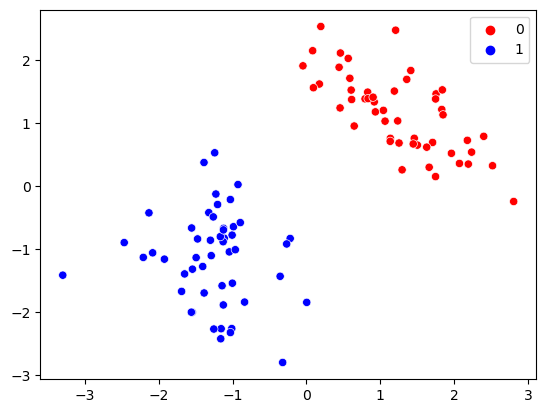

In [11]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=100, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1.2
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, palette=['r', 'b'])

In [17]:
def compute_statistics(X, Y, c):
    means = X[Y == c].mean(axis=0)
    cov = np.cov(X[Y == c], rowvar=False)
    p_c = (Y==c).sum()/len(Y)
    return (means, cov, p_c)

def compute_params(X, Y):
    (mu1, cov1, p_c1), (mu2, cov2, p_c2) = [compute_statistics(X, Y, c) for c in np.unique(Y)]
    pooled_cov = cov1 * p_c1 + cov2 * p_c2
    pooled_cov_inv = np.linalg.pinv(pooled_cov)
    w = pooled_cov_inv @ (mu1 - mu2)
    w0 = -0.5 * (mu1 + mu2).T @ pooled_cov_inv @ (mu1 - mu2) + np.log(p_c1/p_c2)
    return (w, w0)

def p_ci_x(x, mu, cov, p_c):
    cov_inv = np.linalg.pinv(cov)
    det_cov = np.linalg.det(cov)
    return -0.5 * np.log(det_cov) - 0.5 * np.diag((x-mu) @ cov_inv @ (x-mu).T) + np.log(p_c)

# linear transformation
w, w0 = compute_params(X, Y)

pred = 1 * ((w @ X.T + w0) < 0) == Y

pred, w0

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 0.004932103978834396)

In [18]:
sigm = lambda x: 1/(1-np.exp(x))

# sigmoid mapping maps linear discriminant values to 0-1 range
# where 0 is probability of C2 and 1 is probability of C1.
# if p(C1|X) > 0.5, choose C1, otherwise choose C2
1 * (sigm(w @ X.T + w0) > 0.5) == Y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

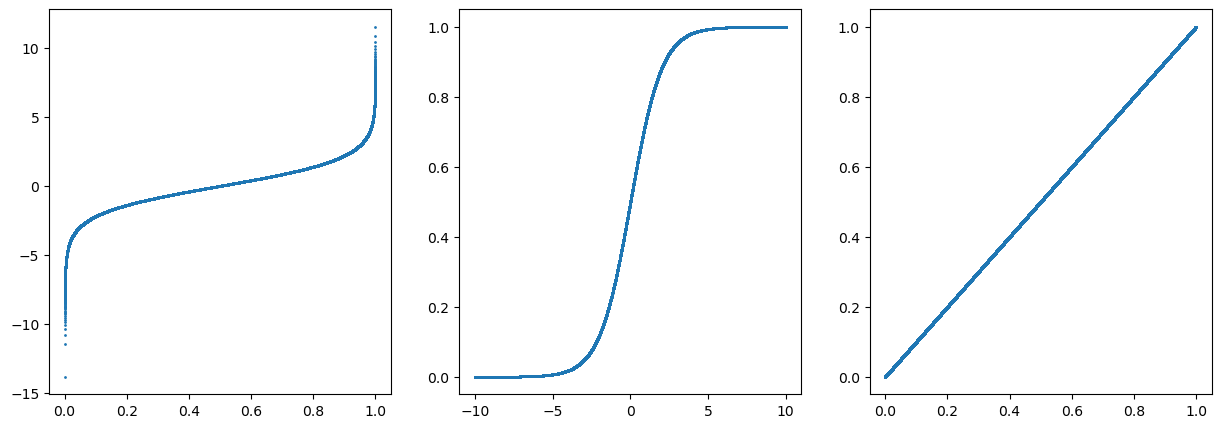

In [19]:
logit = lambda y: np.log(y/(1-y))
sigmoid = lambda y: 1/(1+np.exp(-y))

X_range = np.linspace(0.000001, 0.99999, 100000)
X2_range = np.linspace(-10, 10, 100000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X_range, logit(X_range), s=1)
axes[1].scatter(X2_range, sigmoid(X2_range), s=1)
axes[2].scatter(X_range, sigmoid(logit(X_range)), s=1)

## Logistic discrimination/regression

### Two Classes

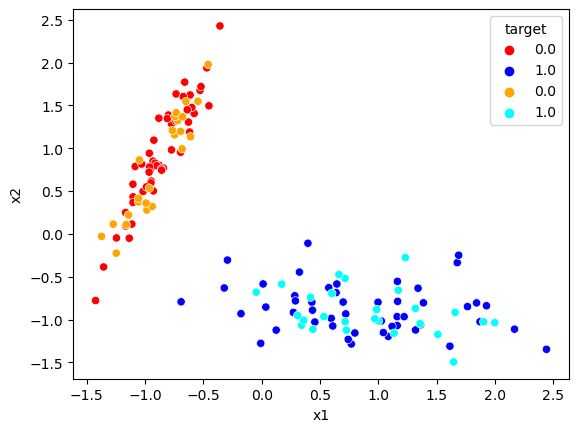

In [340]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=150, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1.2
)

# normalize so that mean zero and unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)

# train/val split
X_val = X[:50, :]
X = X[50:, :]

Y_val = Y[:50]
Y = Y[50:]

train_set = pd.DataFrame(np.concatenate([X, Y[..., None]], axis=1), columns=['x1', 'x2', 'target'])
val_set = pd.DataFrame(np.concatenate([X_val, Y_val[..., None]], axis=1), columns=['x1', 'x2', 'target'])

train = sns.scatterplot(train_set, x='x1', y='x2', hue='target', palette=['r', 'b'])
val = sns.scatterplot(val_set, x='x1', y='x2', hue='target', palette=['orange', 'cyan'])

<AxesSubplot: >

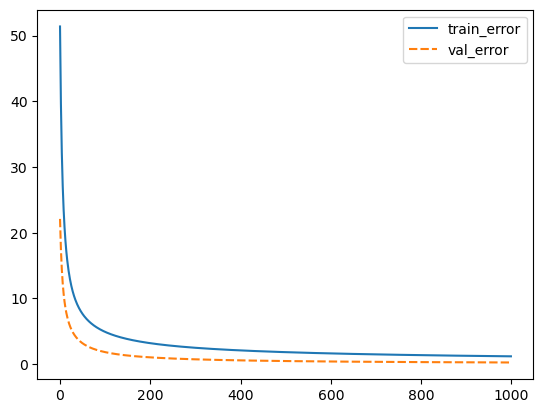

In [341]:
sigmoid = lambda y: 1/(1+np.exp(-y))

# parameters initialised uniformly
w = np.random.uniform(-0.3, 0.3, size=(2, 1))
w0 = np.random.uniform(-0.3, 0.3, size=(1, 1))

# learning rate
lr = 0.003
# number of training epochs
EPOCHS = 1000

# target
y = Y[..., None]
y_val = Y_val[..., None]

history = []

for _ in range(EPOCHS):
    # same as w.T @ X.T + w0 but shape is (1, 100)
    y_pred = sigmoid(X @ w + w0)
    
    # cross entropy
    train_error = -np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))
    # print(error)

    # update via gradient descent
    for i in range(w.shape[0]):
        wj = lr * np.sum((y - y_pred) * X[:, i][..., None])
        w[i, 0] += wj

    w0 += lr * np.sum((y - y_pred))

    val_pred = sigmoid(X_val @ w + w0)
    val_error = -np.sum(y_val * np.log(val_pred) + (1-y_val) * np.log(1-val_pred))
    # print(error)
    history.append([train_error, val_error])

history = pd.DataFrame(history, columns=["train_error", "val_error"])

sns.lineplot(history)

### Multiple classes

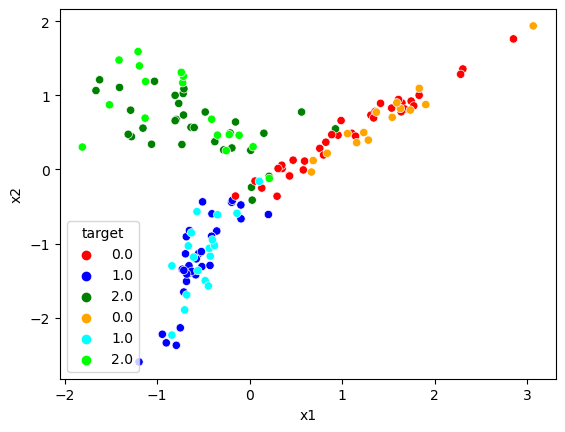

In [344]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=150, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=3,
    n_clusters_per_class=1,
    class_sep=1.4
)

# normalize so that mean zero and unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)

# train/val split
X_val = X[:50, :]
X = X[50:, :]

Y_val = Y[:50]
Y = Y[50:]

train_set = pd.DataFrame(np.concatenate([X, Y[..., None]], axis=1), columns=['x1', 'x2', 'target'])
val_set = pd.DataFrame(np.concatenate([X_val, Y_val[..., None]], axis=1), columns=['x1', 'x2', 'target'])

train = sns.scatterplot(train_set, x='x1', y='x2', hue='target', palette=['r', 'b', 'g'])
val = sns.scatterplot(val_set, x='x1', y='x2', hue='target', palette=['orange', 'cyan', 'lime'])

Y_val = pd.get_dummies(Y_val).to_numpy()
Y = pd.get_dummies(Y).to_numpy()

<AxesSubplot: >

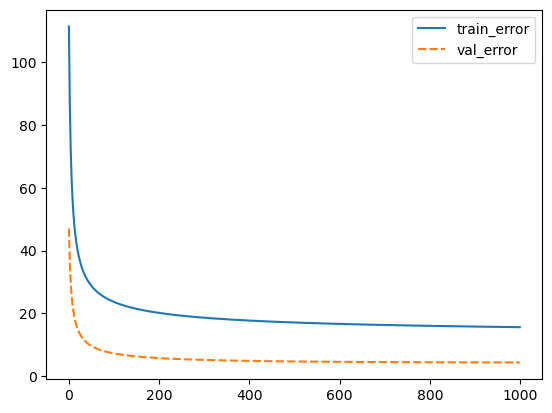

In [345]:
softmax = lambda y: np.exp(y)/(np.sum(np.exp(y), axis=1))[..., None]

# parameters initialised uniformly
w = np.random.uniform(-0.3, 0.3, size=(2, 3))
w0 = np.random.uniform(-0.3, 0.3, size=(1, 3))

# softmax(X @ w + w0)

# learning rate
lr = 0.003
# number of training epochs
EPOCHS = 1000

# target
y = Y
y_val = Y_val

history = []

for _ in range(EPOCHS):

    y_pred = softmax(X @ w + w0)
    train_error = -np.sum(y * np.log(y_pred))
    # print(train_error)

    for j in range(w.shape[1]):
        wj = np.sum(np.broadcast_to((y[:, j] - y_pred[:, j])[..., None], (X.shape[0], 2)) * X, axis=0)
        w[:, j] += lr * wj

        wj0 = np.sum(y[:, j] - y_pred[:, j], axis=0)
        w0[0, j] += lr * wj0

    val_pred = softmax(X_val @ w + w0)
    val_error = -np.sum(y_val * np.log(val_pred))
    history.append([train_error, val_error])

history = pd.DataFrame(history, columns=["train_error", "val_error"])

sns.lineplot(history)

In [347]:
softmax(X_val @ w + w0)[:5, :], y_val[:5, :]

(array([[1.02251656e-03, 9.97727451e-01, 1.25003252e-03],
        [5.73340236e-06, 7.11737294e-06, 9.99987149e-01],
        [9.98081506e-01, 7.84479496e-08, 1.91841601e-03],
        [5.59324144e-05, 9.99939333e-01, 4.73460278e-06],
        [1.17444602e-02, 9.29621727e-01, 5.86338133e-02]]),
 array([[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0]], dtype=uint8))